**Project on Fake or Real news**

In [ ]:
#The main aim of this project is to identify the news articles whether it is fake or true news based on text. By predicting the fake news misinformation can be reduced.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay

import tensorflow
#from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout


# Ignore FutureWarning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/FakeRealNews')

**Data Loading**

In [ ]:
#Data Loading
fake=pd.read_csv("Fake.csv")
true=pd.read_csv("True.csv")


In [ ]:
#By adding 'target' column we are dividing fake & true news
fake['Target']=0
true['Target']=1
df=pd.concat([fake,true])
df

,title,text,subject,date,Target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
11412,Bus drives into pedestrian underpass in Moscow...,MOSCOW (Reuters) - A passenger bus swerved off...,worldnews,"December 25, 2017",1
11413,"Pakistan allows wife, mother to visit Indian m...",ISLAMABAD (Reuters) - Pakistan allowed the wif...,worldnews,"December 25, 2017",1
11414,Iran confirms upholding death sentence for aca...,DUBAI (Reuters) - Iran s Supreme Court has uph...,worldnews,"December 25, 2017",1
11415,"Pope, on Christmas Eve, says faith demands res...",VATICAN CITY (Reuters) - Pope Francis strongly...,worldnews,"December 24, 2017",1


**Data Exploration**

In [ ]:
#Data Exploration
#In this stage, i observed the challenges like having special characters, to remove stopwords,
# Tokenisation, lemmatization, converting text to lower case, Vectorization, duplicate data & missing values founded, type casting required for date column
df.columns
df.dtypes
#df.describe(include='all')

,0
title,object
text,object
subject,object
date,object
Target,int64


In [ ]:
df.isnull().sum()

,0
title,3
text,3
subject,6
date,6
Target,0


In [ ]:
print(df.duplicated().sum())


67


**Data Preprocessing**

In [ ]:
#removing duplicates
df = df.drop_duplicates()
print(df.duplicated().sum())

0


In [ ]:
#handling missing values
# Fill missing values in title, text, and subject
df['title'].fillna('Unknown', inplace=True)
df['text'].fillna('Unknown', inplace=True)
df['subject'].fillna('Unknown', inplace=True)

df.isnull().sum()


<ipython-input-42-50e834e68368>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'].fillna('Unknown', inplace=True)
<ipython-input-42-50e834e68368>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'].fillna('Unknown', inplace=True)
<ipython-input-42-50e834e68368>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject'].fillna('Unknown', inplace=True)


,0
title,0
text,0
subject,0
date,4
Target,0


In [ ]:
#checking for missing data for variable 'date'
# Filter rows where the 'date' column has missing values
missing_date_rows = df[df['date'].isnull()]

# Display rows with dates missing
print(missing_date_rows)

                                                   title  \
9731   ANTI-AMERICAN GEORGE SOROS Locks Arms With NFL...   
9732                                             Unknown   
12408  WOW! AMERICA IS UNDER ATTACK By These 187 Orga...   
13364  A MUST READ! Here’s Why Voting For DONALD TRUM...   

                                                    text  subject date  Target  
9731   We just discovered another reason NOT to suppo...  Unknown  NaN       0  
9732                                             Unknown  Unknown  NaN       0  
12408  There have been many articles written about Ge...  Unknown  NaN       0  
13364  This is a must read for anyone who s undecided...  Unknown  NaN       0  


In [ ]:
#to handle missing data for 'date' variable either replace with near date or drop or mean \ median imputation tech.

# Drop rows with missing target or date values
#df.dropna(subset=['Target', 'date'], inplace=True)

In [ ]:
#imputation
# Filling missing dates with the mean date
df['date'] = pd.to_datetime(df['date'], errors='coerce') # converting to date format

mean_date = df['date'].mean()
print(f"The mean date is: {mean_date}") #checking mean date

df['date'].fillna(mean_date, inplace=True)



The mean date is: 2016-10-15 04:09:43.783783680


<ipython-input-44-0c0c2014ef91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce') # converting to date format
<ipython-input-44-0c0c2014ef91>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'].fillna(mean_date, inplace=True)


In [ ]:
df.head()

,title,text,subject,date,Target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0


In [ ]:
#This is for text preprocessing such as text normalization, tokenization, stemming\lemmatization, to remove stop words, special characters, links, numbers etc.,
#stemming
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import regexp_tokenize
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Define the preprocessing function
def wp(text):
    # Lowercase conversion
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'\W+|\d+', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Reconstruct text from tokens
    stem_cleaned_text = ' '.join(tokens)
    return stem_cleaned_text

In [ ]:
df['stem_cleaned_text'] = df['text'].apply(wp)

<ipython-input-48-50f9520a11b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stem_cleaned_text'] = df['text'].apply(wp)


In [ ]:
#Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import regexp_tokenize

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# Function to map POS tags to WordNet POS
def get_wordnet_pos(word):
    """Map POS tag to WordNet POS for better lemmatization."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to NOUN if no mapping available

# Preprocessing function with lemmatization
def wp1(text):
    # Lowercase conversion
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and numbers
    text = re.sub(r'\W+|\d+', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

    # Reconstruct text from tokens
    lemma_cleaned_text1 = ' '.join(tokens)
    return lemma_cleaned_text1




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
# Apply the function to the dataframe
df['lemma_cleaned_text1'] = df['text'].apply(wp1)

<ipython-input-51-b04f62cd863d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemma_cleaned_text1'] = df['text'].apply(wp1)


In [ ]:
df.head() # understanding difference b/w stemming and lemmatization for cleaned data

,title,text,subject,date,Target,stem_cleaned_text,lemma_cleaned_text1
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,donald trump wish american happi new year leav...,donald trump wish american happy new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,hous intellig committe chairman devin nune go ...,house intelligence committee chairman devin nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,friday reveal former milwauke sheriff david cl...,friday reveal former milwaukee sheriff david c...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,christma day donald trump announc would back w...,christmas day donald trump announce would back...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,pope franci use annual christma day messag reb...,pope francis use annual christmas day message ...


**Exploratory Data Analysis**

Target
0    13501
1    11354
Name: count, dtype: int64


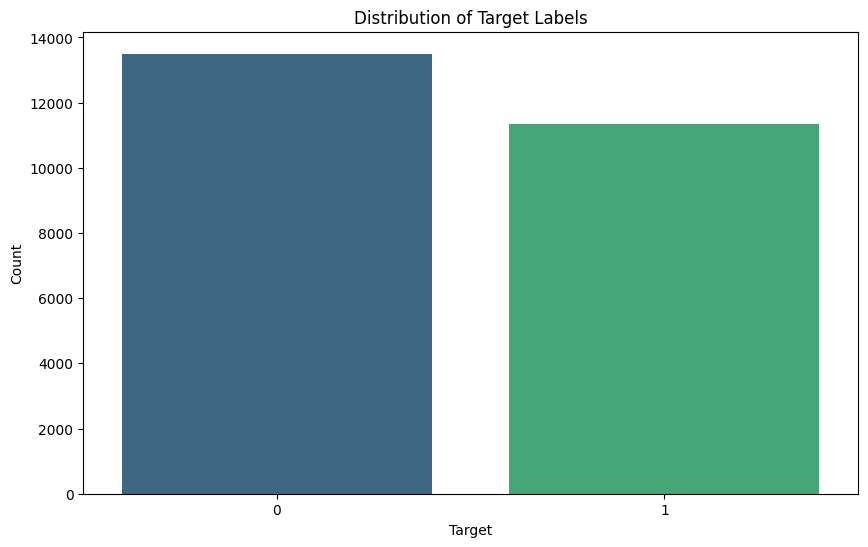

In [ ]:
#Univariant analysis
#1 Target variable
Target_distribution = df['Target'].value_counts()
print(Target_distribution)

# Plot the Target variable distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=Target_distribution.index, y=Target_distribution.values, palette='viridis')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.show()

<ipython-input-57-5d71ef54b28f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['lemma_cleaned_text1'].apply(len)


Text Length Statistics:
count    24855.000000
mean      1637.106578
std       1099.346665
min          0.000000
25%       1016.000000
50%       1510.000000
75%       2037.500000
max      24667.000000
Name: text_length, dtype: float64


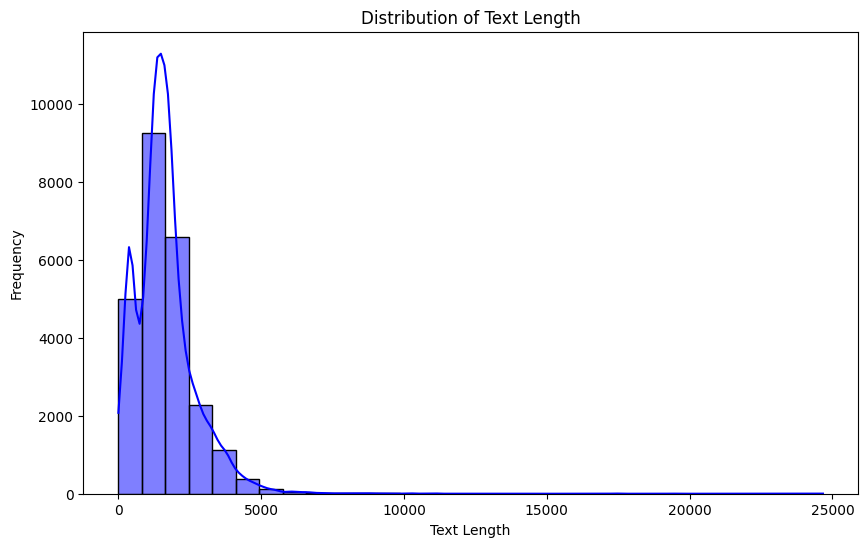

In [ ]:
# 2. Text Length Distribution

df['text_length'] = df['lemma_cleaned_text1'].apply(len)

# Print basic statistics about text length
print("Text Length Statistics:")
print(df['text_length'].describe())

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

<ipython-input-67-243d026d77d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df['lemma_cleaned_text1'].apply(lambda x: len(x.split()))


Word Count Statistics:
count    24855.000000
mean       233.606799
std        155.506849
min          0.000000
25%        147.000000
50%        217.000000
75%        291.000000
max       3904.000000
Name: word_count, dtype: float64


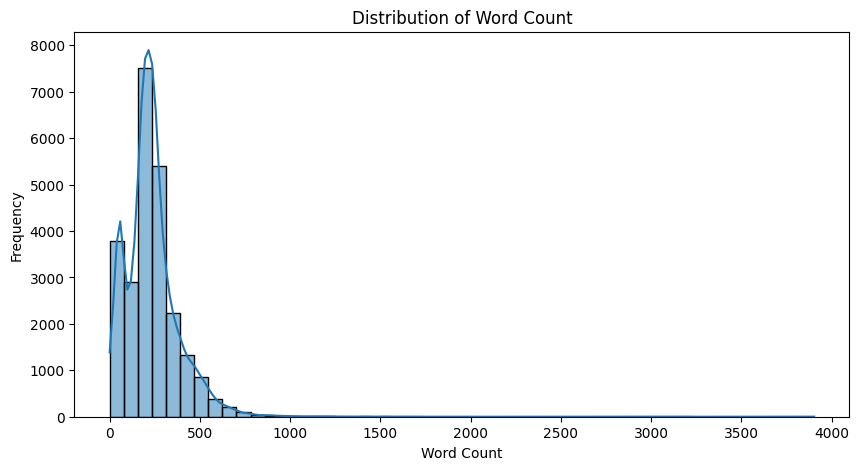

In [ ]:
#3.word count distribution
df['word_count'] = df['lemma_cleaned_text1'].apply(lambda x: len(x.split()))

print("Word Count Statistics:")
print(df['word_count'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


subject
politicsNews                                                                                                             11219
News                                                                                                                      9050
politics                                                                                                                  4027
worldnews                                                                                                                  134
Unknown                                                                                                                      4
 of which Soros is a major financier.Mercy Corps: Vis a vis the Arab-Israeli conflict                                        1
 high taxes                                                                                                                  1
 Politics According to the Bible and (with Barry Asmus) The Poverty of Nations: A Sustainable Solution.

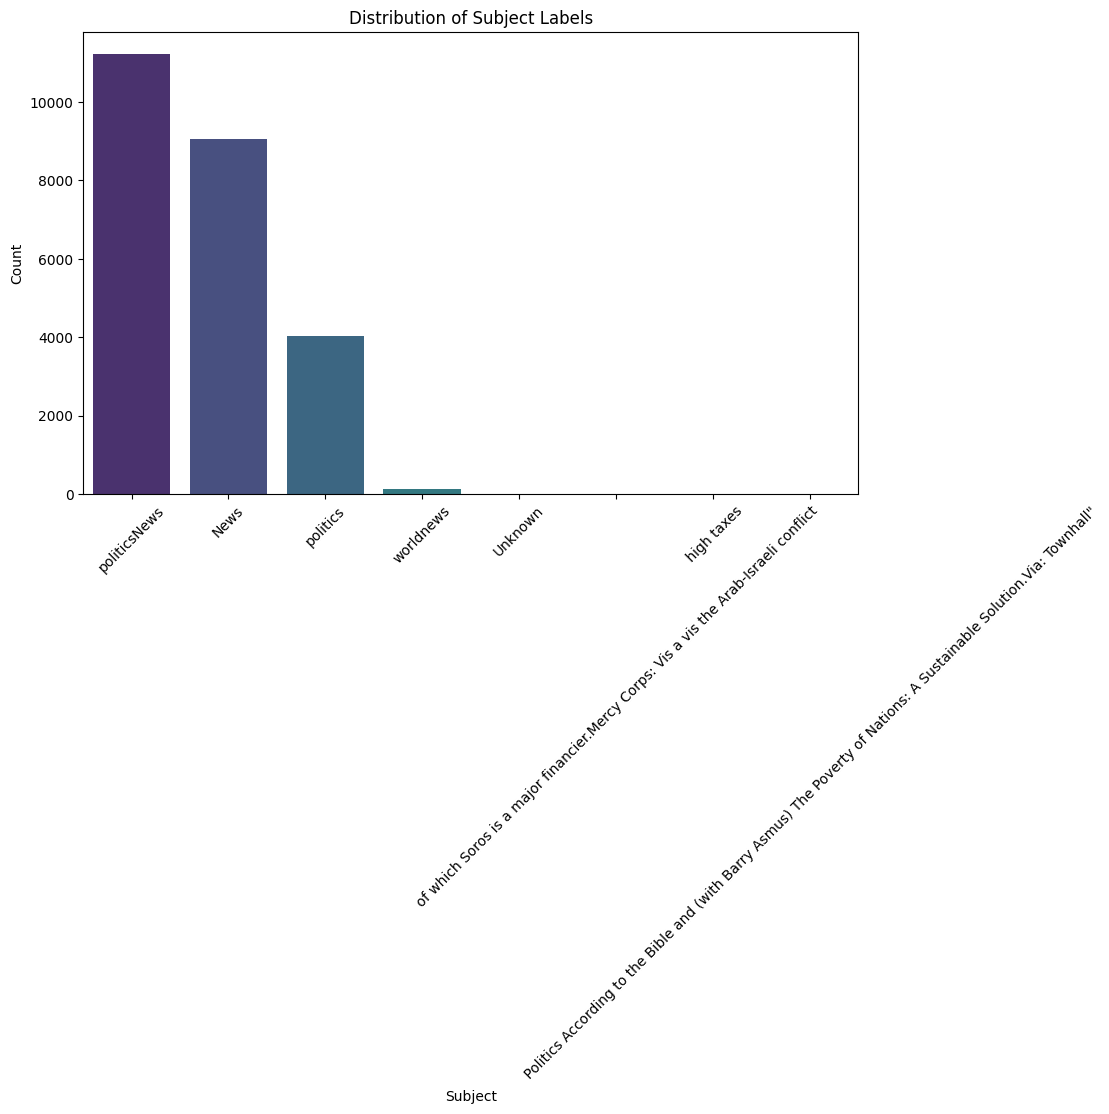

In [ ]:
#Subject variable
Subject_distribution = df['subject'].value_counts()
print(Subject_distribution)

# Plot the Target variable distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=Target_distribution.index, y=Subject_distribution.values, palette='viridis')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.title('Distribution of Subject Labels')
plt.xticks(rotation=45)
plt.show()

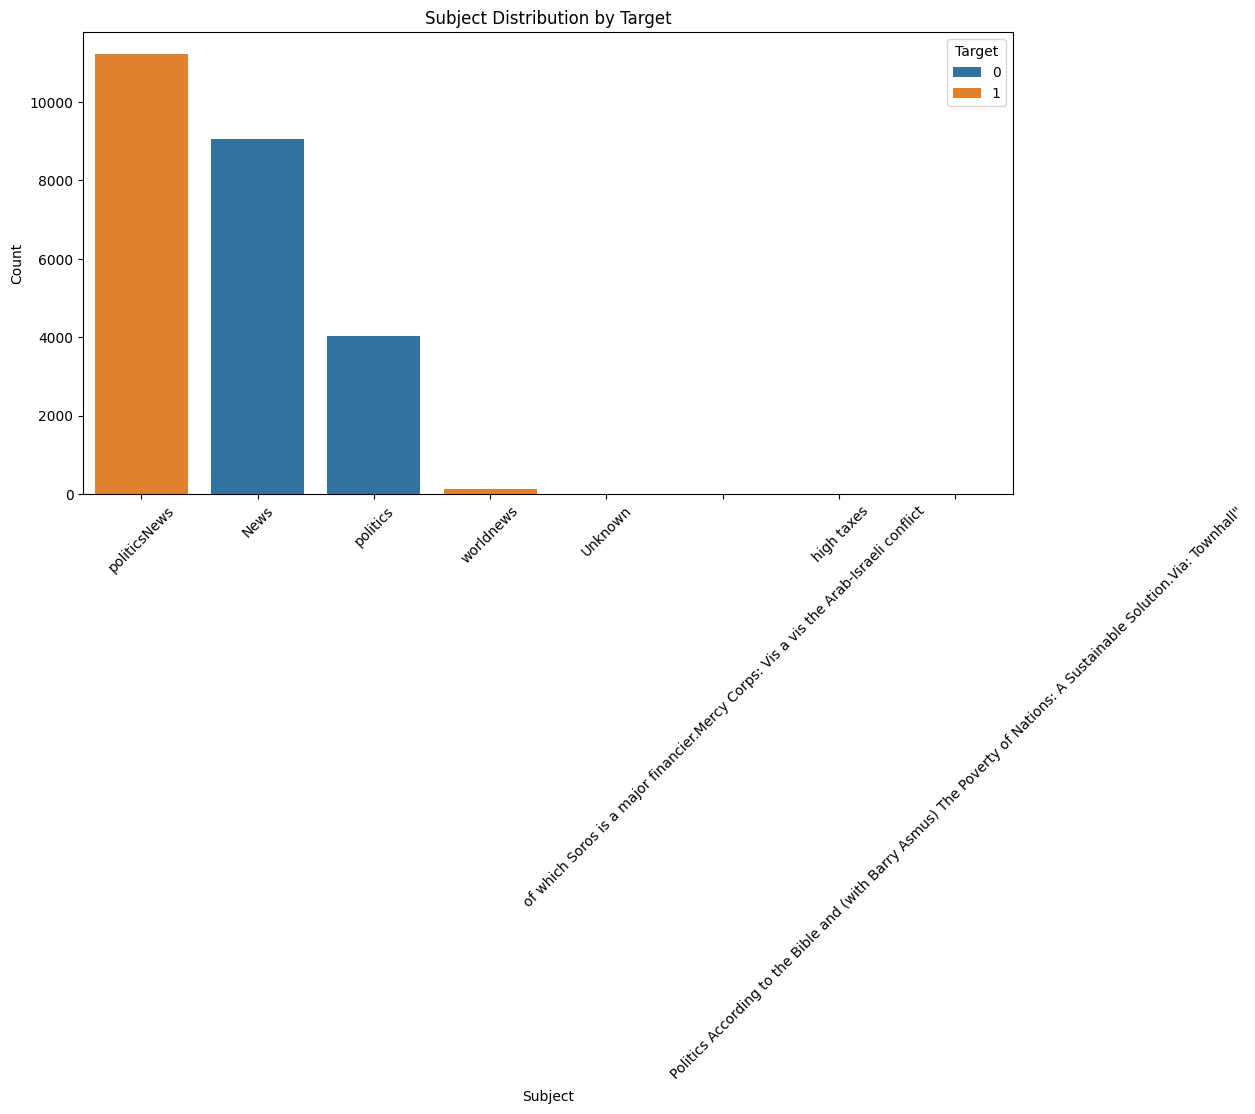

In [ ]:
#Bivariant analysis
#Target vs Subject
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='subject', hue='Target', order=df['subject'].value_counts().index)
plt.title('Subject Distribution by Target')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Target', loc='upper right')
plt.show()


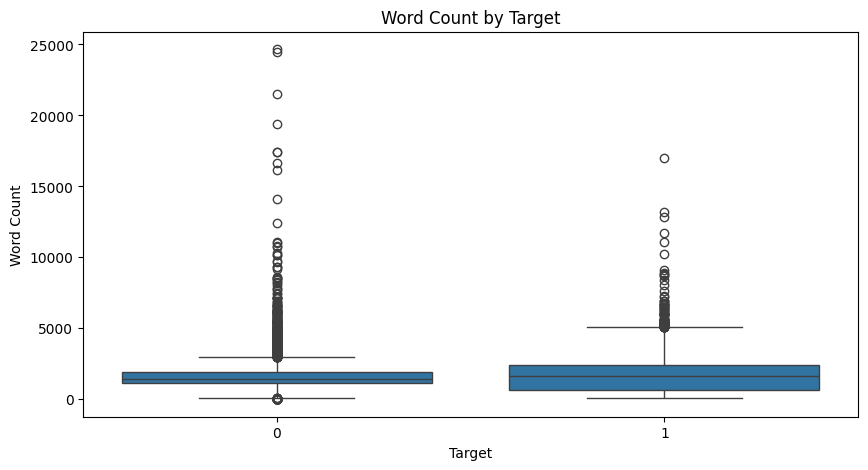

In [ ]:
#Target vs word count
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Target', y='word_count')
plt.title('Word Count by Target')
plt.xlabel('Target')
plt.ylabel('Word Count')
plt.show()


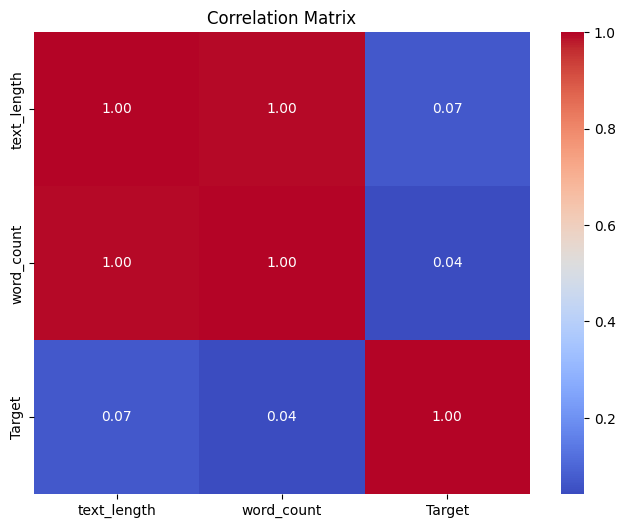

In [ ]:
correlation_matrix = df[['text_length', 'word_count', 'Target']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
df.head()

,title,text,subject,date,Target,stem_cleaned_text,lemma_cleaned_text1,text_length,word_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,donald trump wish american happi new year leav...,donald trump wish american happy new year leav...,1760,266
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,hous intellig committe chairman devin nune go ...,house intelligence committee chairman devin nu...,1315,184
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,friday reveal former milwauke sheriff david cl...,friday reveal former milwaukee sheriff david c...,2294,340
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,christma day donald trump announc would back w...,christmas day donald trump announce would back...,1742,263
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,pope franci use annual christma day messag reb...,pope francis use annual christmas day message ...,1388,212


In [ ]:
#here i am doing splitting before vectorization because split data i want to use in LSTM i.e., X_train....etc  this TF_IDF or BOW trained data we can't use in LSTM 'embedding' will use there
X = df['lemma_cleaned_text1']
y = df['Target']
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

we can't use this TF_IDF or BOW trained data for advanced models like LSTM  'embedding(Glove / Bert/ Word2vec)' will use

**Vectorization**

In [ ]:
#Apply TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Check the shape of the TF-IDF matrix
print("TF-IDF Matrix Shape:", X_train_tfidf.shape)

TF-IDF Matrix Shape: (19549, 5000)


In [ ]:
# to see vectorization
#1. View the Words (Features) Generated by TF-IDF
#Once you’ve fitted the TfidfVectorizer on the text data, you can check the vocabulary (i.e., the unique words used as features).
#The TfidfVectorizer stores this information in its vocabulary_ attribute, and the words are indexed according to their position in the resulting matrix.
# Get the feature names (i.e., the words in the vocabulary)

tfidf_feature_names = tfidf.get_feature_names_out()

# Print the first 20 feature names (words)
print("First 20 words in the vocabulary:")
print(tfidf_feature_names[:20])

First 20 words in the vocabulary:
['aaron' 'abandon' 'abbott' 'abc' 'abe' 'abedin' 'abide' 'ability' 'able'
 'aboard' 'abolish' 'abortion' 'abroad' 'abruptly' 'absence' 'absolute'
 'absolutely' 'absurd' 'abuse' 'aca']


In [ ]:
#2 The TF-IDF matrix is stored in the variable X, which is a sparse matrix. To view the matrix in a more readable format,
#you can convert it into a dense matrix.


# Convert the sparse TF-IDF matrix into a dense matrix (if you want to see actual values, be careful with large data)
dense_tfidf = X_train_tfidf.todense()

# Check the shape of the matrix
print(f"Shape of the TF-IDF matrix: {dense_tfidf.shape}")

# Convert the first row (representing the first document) to a list
first_doc_tfidf = dense_tfidf[0].tolist()[0]

# Pair the feature names (words) with their corresponding TF-IDF scores for the first document
tfidf_scores_first_doc = [(word, first_doc_tfidf[i]) for i, word in enumerate(tfidf_feature_names)]

# Sort the TF-IDF scores in descending order to see the most important words
tfidf_scores_first_doc_sorted = sorted(tfidf_scores_first_doc, key=lambda x: x[1], reverse=True)

# Print the top 10 TF-IDF scores for the first document
print("Top 10 words by TF-IDF score in the first document:")
for word, score in tfidf_scores_first_doc_sorted[:10]:
    print(f"{word}: {score:.4f}")


 #Explanation:
#todense(): Converts the sparse matrix into a dense matrix where each row represents a document and each column represents a word (with the value being the TF-IDF score).
#tfidf_feature_names: Contains the vocabulary (i.e., the list of words) that were learned by the TfidfVectorizer.
#first_doc_tfidf: This is the TF-IDF score vector for the first document in dataset. Each value represents the importance of the word (corresponding to the same index in the tfidf_feature_names array) in the document.

Shape of the TF-IDF matrix: (19549, 5000)
Top 10 words by TF-IDF score in the first document:
microcephaly: 0.3994
elect: 0.3626
reconsider: 0.3559
freak: 0.2848
handgun: 0.2442
hit: 0.2156
true: 0.1690
commercial: 0.1460
fact: 0.1373
right: 0.1293


In [ ]:
#3. View TF-IDF Scores for All Documents
# Check TF-IDF scores for the first 5 documents
for doc_num in range(5):
    doc_tfidf = dense_tfidf[doc_num].tolist()[0]
    tfidf_scores_doc = [(word, doc_tfidf[i]) for i, word in enumerate(tfidf_feature_names)]
    tfidf_scores_doc_sorted = sorted(tfidf_scores_doc, key=lambda x: x[1], reverse=True)

    print(f"\nTop 5 words by TF-IDF score in document {doc_num + 1}:")
    for word, score in tfidf_scores_doc_sorted[:5]:
        print(f"{word}: {score:.4f}")

#The words "microcephaly", "elect", and "reconsider" have the highest TF-IDF scores for the first document.etc.,
#This means they are important to that particular document compared to other words.


Top 5 words by TF-IDF score in document 1:
microcephaly: 0.3994
elect: 0.3626
reconsider: 0.3559
freak: 0.2848
handgun: 0.2442

Top 5 words by TF-IDF score in document 2:
sanctuary: 0.4108
presence: 0.2848
kellyanne: 0.2821
poverty: 0.2608
scale: 0.1942

Top 5 words by TF-IDF score in document 3:
municipal: 0.3270
series: 0.2712
killing: 0.2599
proclaim: 0.2115
consistently: 0.2056

Top 5 words by TF-IDF score in document 4:
veteran: 0.6313
hit: 0.1533
militia: 0.1240
work: 0.1192
announce: 0.1190

Top 5 words by TF-IDF score in document 5:
warrant: 0.4030
fda: 0.3443
man: 0.2990
fish: 0.2630
source: 0.2112


**Modelling**

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Build a Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_logreg = logreg.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99


In [ ]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"

def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = logreg.predict(new_xv_test)
    # pred_DT = DT.predict(new_xv_test)
    # pred_GBC = GBC.predict(new_xv_test)
    # pred_RFC = RFC.predict(new_xv_test)

    return print("\n\nLR Prediction: {}".format(output_lable(pred_LR[0])))

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Build a Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_nb = nb.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_nb)
print(f'Accuracy: {accuracy:.2f}')



Accuracy: 0.93


In [ ]:
from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svc = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svc)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.99


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression Evaluation
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# Naive Bayes Evaluation
print("\nNaive Bayes - Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Naive Bayes Evaluation
print("\nSVC - Classification Report:")
print(classification_report(y_test, y_pred_svc))

# Confusion Matrix for both models
print("\nConfusion Matrix - Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))

print("\nConfusion Matrix - Naive Bayes:")
print(confusion_matrix(y_test, y_pred_nb))

# Confusion Matrix for both models
print("\nConfusion Matrix - SVC:")
print(confusion_matrix(y_test, y_pred_svc))



Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2627
           1       0.98      0.99      0.99      2261

    accuracy                           0.99      4888
   macro avg       0.99      0.99      0.99      4888
weighted avg       0.99      0.99      0.99      4888


Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2627
           1       0.92      0.93      0.93      2261

    accuracy                           0.93      4888
   macro avg       0.93      0.93      0.93      4888
weighted avg       0.93      0.93      0.93      4888


SVC - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2627
           1       0.99      0.99      0.99      2261

    accuracy                           0.99      4888
   macro avg  

# **LSTM**


In [ ]:
# Parameters
max_words = 10000  # Vocabulary size
max_len = 100      # Maximum length of sequences

# Tokenization on the original text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # Use original text data here
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))  # Binary classification

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model
model_lstm.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test))



Epoch 1/5
611/611 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.9309 - loss: 0.2220 - val_accuracy: 0.9771 - val_loss: 0.0620
Epoch 2/5
611/611 ━━━━━━━━━━━━━━━━━━━━ 84s 131ms/step - accuracy: 0.9882 - loss: 0.0422 - val_accuracy: 0.9646 - val_loss: 0.0930
Epoch 3/5
611/611 ━━━━━━━━━━━━━━━━━━━━ 92s 148ms/step - accuracy: 0.9908 - loss: 0.0308 - val_accuracy: 0.9740 - val_loss: 0.1099
Epoch 4/5
611/611 ━━━━━━━━━━━━━━━━━━━━ 81s 132ms/step - accuracy: 0.9953 - loss: 0.0151 - val_accuracy: 0.9742 - val_loss: 0.0875
Epoch 5/5
611/611 ━━━━━━━━━━━━━━━━━━━━ 82s 133ms/step - accuracy: 0.9975 - loss: 0.0090 - val_accuracy: 0.9769 - val_loss: 0.1153


In [ ]:
# Evaluate the LSTM model
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")

153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9784 - loss: 0.1085
LSTM Model Accuracy: 97.69%


# Deployment

In [ ]:
#steps -
#1) save our trained model using pickle or joblib file -- i.e., dump the file & load the model.
#2) create web app using Flask \ FastAPI \ streamlit \ Django -- that loads the model(pickle or joblib) and vectorizer, accepts incoming news articles, and returns predictions.
# eg:- consider flask app -- steps - create Flask app(initialize), load the model file(pickle or joblib) & vectorize file to read it,

In [ ]:
import pickle

# Save the model to a file
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(logreg, file)

print("Model saved successfully as 'logistic_model.pkl'")

Model saved successfully as 'logistic_model.pkl'


In [ ]:
# Load the model from the pickle file
with open('logistic_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Example prediction
y_pred1 = loaded_model.predict(X_test_tfidf)
print(y_pred1)


[1 1 0 ... 0 1 1]


In [ ]:
# from flask import Flask, request, jsonify
# import pickle

# # Load the saved model
# with open('logistic_model.pkl', 'rb') as file:
#     model = pickle.load(file)

# app = Flask(__name__)

# @app.route('/predict', methods=['POST'])
# def predict():
#     # Get data from POST request
#     data = request.json
#     # Assuming the input is a list of features
#     prediction = model.predict([data['features']])
#     return jsonify({'prediction': int(prediction[0])})

# if __name__ == '__main__':
#     app.run(debug=True)
